# Exercise: Rootfinding

In [1]:
import os
from casadi import *
from pylab import *

In [2]:
plot_dir = 'plots'
if not os.path.exists(plot_dir):
    os.mkdir(plot_dir)

In [3]:
def g(w):
    x = w[0]
    y = w[1]
    g1 = tanh((x + 2) * y**2 / 25 - 0.5)
    g2 = sin(x) - 0.5 * y + 1
    return vertcat(g1, g2)

In [4]:
x0 = vertcat(-0.8, 2)
g_test = g(x0)
g_test

DM([-0.298617, -0.717356])

In [5]:
assert g_test.shape == (2, 1)
assert np.max(np.abs(g_test - DM([-0.2986,-0.7174]))) < 1e-4

## Finite differences

In [6]:
def estimate_Jacobian(f, x0, eps=1e-8):
    """Estimate the Jacobian matrix of function f(x) at x = x0
    using finite differences.
    """
    nx = x0.shape[0]
    assert x0.shape[1] == 1
    eps = DM(eps)
    if eps.shape[0] == 1:
        eps = repmat(eps, nx)
    f0 = f(x0)
    nf = f0.shape[0]
    assert f0.shape[1] == 1
    dFdx_cols = []
    for i in range(nf):
        dx = DM.zeros(nx, 1)
        dx[i] = eps[i]
        Fx_p1 = f(x0 + dx)
        dFdx_cols.append((Fx_p1 - f0) / eps[i])
    return horzcat(*dFdx_cols)


In [7]:
x0 = vertcat(-0.8, 2)
J_test = estimate_Jacobian(g, x0, eps=1e-6)
J_test

DM(
[[0.145733, 0.174879], 
 [0.696707, -0.5]])

In [8]:
assert J_test.shape == (2, 2)
assert np.max(np.abs(J_test - DM([[0.1457, 0.1749], [0.6967, -0.5000]]))) < 1e-4

## Plot variation of g(x)

In [9]:
def plot_func_variation(g, x0, x_min, x_max, x_pts=None, J=None, n=51):
    g0 = array(g(x0)).reshape(-1)
    ng = g0.shape[0]
    if x_pts is not None:
        g_pts = [array(g(x_pt)) for x_pt in x_pts]
        x_pts = [array(x_pt) for x_pt in x_pts]
    x0 = array(x0).reshape(-1)
    x_min = array(x_min).reshape(-1)
    x_max = array(x_max).reshape(-1)
    x_ranges = linspace(x_min, x_max, n)
    nx = x_ranges.shape[1]
    nk = x_ranges.shape[0]
    if J is not None:
        J = array(J)
        G_lin = np.zeros((2, nx, ng))
        for i in range(nx):
            X = np.repeat(x0.reshape(1, -1), 2, 0)
            X[:, i] = x_ranges[[0, -1], i]
            G_lin[0, i, :] = g0 + J @ (X[0, :] - x0)
            G_lin[1, i, :] = g0 + J @ (X[1, :] - x0)
    G = np.zeros((nk, nx, ng))
    for i in range(nx):
        X = np.repeat(x0.reshape(1, -1), nk, 0)
        X[:, i] = x_ranges[:, i]
        for k in range(X.shape[0]):
            G[k, i, :] = array(g(X[k, :].T)).reshape(-1)
    for j in range(ng):
        for i in range(nx):
            subplot(ng, nx, j*2+i+1)
            plot(x_ranges[:, i], G[:, i, j], label=f'$g_{j+1}(x)$')
            g_min, g_max = G[:, i, j].min(), G[:, i, j].max()
            if x_pts is not None:
                for k, (x_pt, g_pt) in enumerate(zip(x_pts, g_pts)):
                    plot(x_pt[i], g_pt[j], '.', color='k',
                         label=f'$g_{j+1}(x^{k})$')
                    annotate(f'{k}', xy=(x_pt[i], g_pt[j]), 
                             xytext=(0, 6), textcoords='offset points', 
                             ha='center')
            if J is not None:
                # Only show linear approx. for x0 point
                plot(x_ranges[[0, -1], i], G_lin[:, i, j], '--')
                g_min, g_max = min(g_min, G_lin[:, i, j].min()), max(g_max, G_lin[:, i, j].max())
            xlim(x_ranges[[0, -1], i])
            ylim([g_min, g_max])
            xlabel(f'$x_{i+1}$')
            ylabel(f'$g_{j+1}(x)$')
            grid()
    tight_layout()


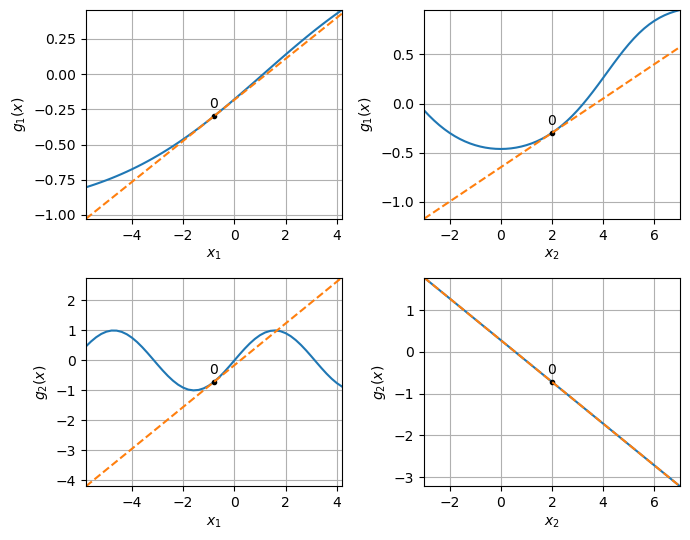

In [10]:
x_pts = [x0]
J = estimate_Jacobian(g, x0, eps=1e-6)
x_min = array(x0).reshape(-1) - 5
x_max = array(x0).reshape(-1) + 5
figure(figsize=(7, 5.5))
plot_func_variation(g, x0, x_min, x_max, J=J, x_pts=x_pts)

## Newton steps

In [11]:
x0 = vertcat(-0.8, 2)
J = estimate_Jacobian(g, x0, eps=1e-6)
dx = solve(J, -g(x0))
x1 = x0 + dx
x1

DM([0.611149, 2.5316])

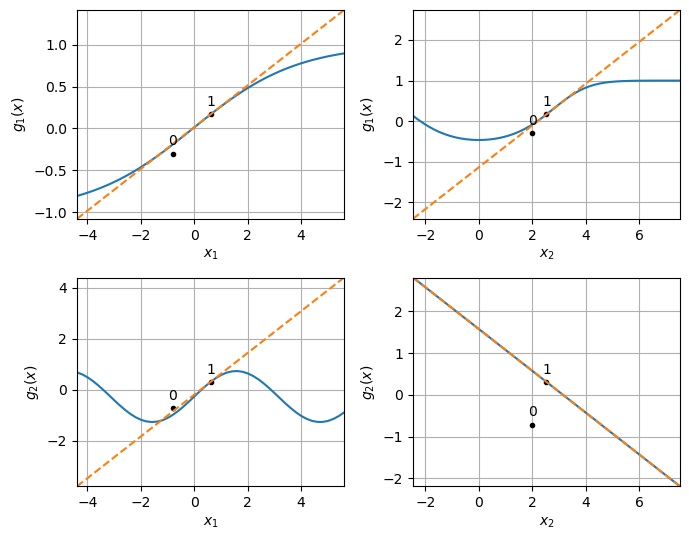

In [12]:
x_pts = [x0, x1]
J = estimate_Jacobian(g, x1, eps=1e-6)
x_min = array(x1).reshape(-1) - 5
x_max = array(x1).reshape(-1) + 5
figure(figsize=(7, 5.5))
plot_func_variation(g, x1, x_min, x_max, J=J, x_pts=x_pts)

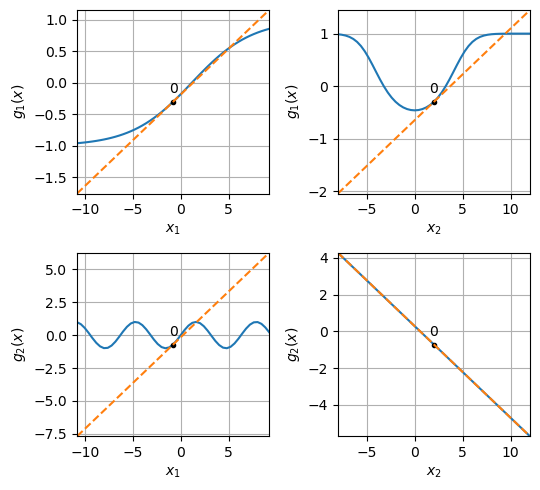

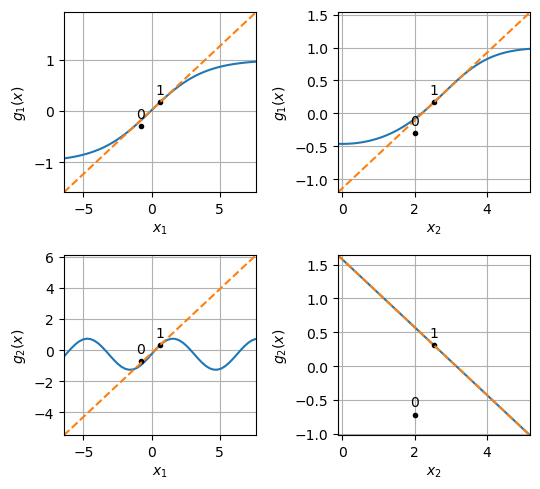

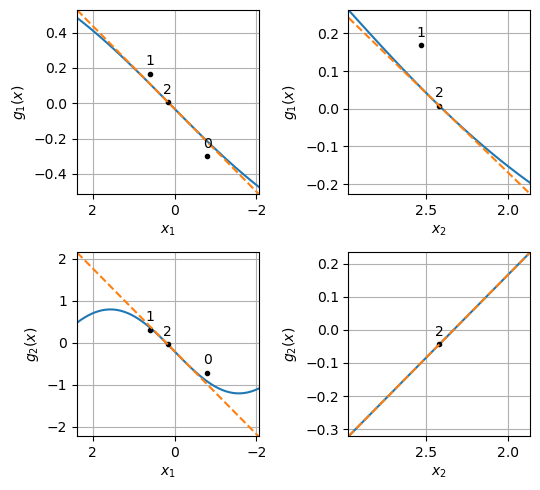

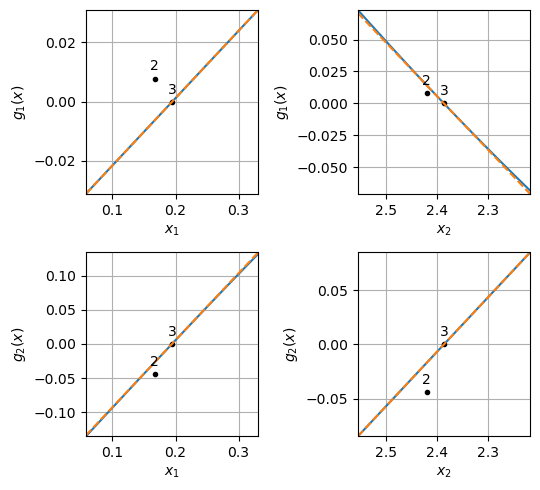

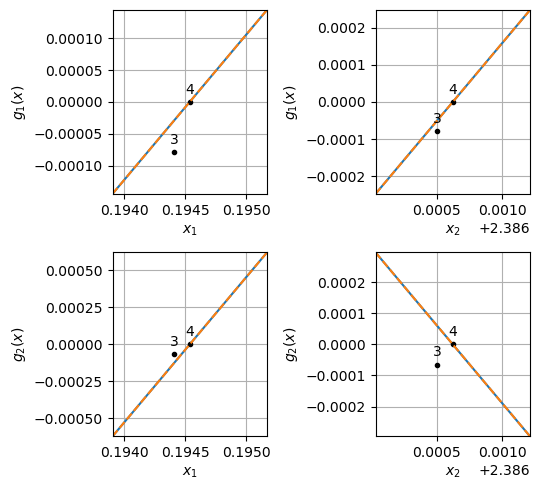

In [13]:
x0 = vertcat(-0.8, 2)
x_pts = [x0]
x = x0
dx = DM([2, 2])
for i in range(5):
    J = estimate_Jacobian(g, x, eps=1e-6)

    figure(figsize=(5.5, 5))
    x_min = array(x - dx * 5).reshape(-1) 
    x_max = array(x + dx * 5).reshape(-1)
    plot_func_variation(g, x, x_min, x_max, J=J, x_pts=x_pts)
    filename = f'newton_step_{i+1}.pdf'
    savefig(os.path.join(plot_dir, filename))

    dx = solve(J, -g(x))
    x += dx
    x_pts.append(x)


In [14]:
x_pts

[DM([-0.8, 2]),
 DM([0.611149, 2.5316]),
 DM([0.167149, 2.42036]),
 DM([0.194409, 2.3865]),
 DM([0.194536, 2.38662]),
 DM([0.194536, 2.38662])]

In [15]:
assert np.max(np.abs(x_pts[5] - [0.1945, 2.3866]) < 1e-4)